# Test training and inference lambda with sample data

##### This notebook showcases the usage of the training and inference lamnbda by creating sample data and invoking the lambda functions.

## 01) Imports & Setup

In [1]:
import boto3
from sklearn import datasets
import json
import matplotlib.pyplot as plt
import requests

In [2]:
# boto 3 lambda client to invoke the lambda functions programatically
lambda_client = boto3.client('lambda')

In [7]:
# Set lambda function names

# inference lambda function
inference_function_name = 'serverless-online-ml-InferenceFunction-bxQeYo537CcM' # replace with your lambda function name
# training lambda function
training_function_name = 'serverless-online-ml-TrainingFunction-tYJdugW7BMBQ' # replace with your lambda function name

## 02) Test Access to Lambda function

First we test whether we have sufficient IAM permissions to invoke the two lambda functions

In [8]:
# invoke lambda in "dry-run" mode
response = lambda_client.invoke(
    FunctionName=inference_function_name,
    InvocationType='DryRun',
    LogType='Tail'
)

# check if statuscode indicates successful access
if response.get('StatusCode') == 204:
    print('Access to inference lambda function successful')
else:
    print('Access to inference lambda function not successful. Please make sure your notebook\'s IAM role has sufficient permissions to invoke the lambda function.')

Access to inference lambda function successful


In [9]:
# invoke lambda in "dry-run" mode
response = lambda_client.invoke(
    FunctionName=training_function_name,
    InvocationType='DryRun',
    LogType='Tail'
)

# check if statuscode indicates successful access
if response.get('StatusCode') == 204:
    print('Access to training lambda function successful')
else:
    print('Access to training lambda function not successful. Please make sure your notebook\'s IAM role has sufficient permissions to invoke the lambda function.')

Access to training lambda function successful


## 03) Test Lambda Function

### 03a) Training

Now that we have ensured sufficient IAM permissions, we can test the training lambda functions with sample data.

In [10]:
# create sample data
X, y = datasets.make_regression(
    n_samples=500,
    n_features=1,
    n_informative=1,
    n_targets=1,
    bias=20,
    noise=30
)

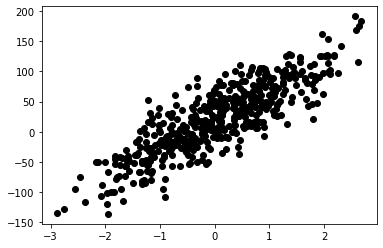

In [11]:
# inspect the training data
plt.scatter(X, y,  color='black')

We can see that our data can be approximated with a linear regression.

In [12]:
# prepare payload
data = {
    "data": {
        "X": X.tolist(),
        "y": y.tolist()
    }
}
event = {
    "body": json.dumps(data)
}
payload = json.dumps(event)

In [13]:
# invoke training lambda
# the first call will take longer than succeeding ones, as the lambda function warms up after a period of inactiveness. 
response = lambda_client.invoke(
    FunctionName=training_function_name,
    InvocationType='RequestResponse',
    LogType='Tail',
    Payload=payload
)

In [14]:
# investigate response
response_payload = response.get('Payload').read()
print(json.loads(response_payload))

{'statusCode': 200, 'body': '{"training": "success", "mean_squared_error": 468.51680717101283, "r_squared": 0.7255243071505112}'}


### 03b) Inference

Now that we have successfully invoked the training lambda, which trained a regression model and saved the trained model to s3, 
we can test the inference lambda. It will download the latest trained model from s3 and make predictions based on the
data we we send in with the invocation call. 

In [15]:
# create sample inference data
X_test, y_test = datasets.make_regression(
    n_samples=10,
    n_features=1,
    n_informative=1,
    n_targets=1,
    bias=30,
    noise=50
)

In [16]:
# prepare payload
data = {
    "data": X_test.tolist()
}
event = {
    "body": json.dumps(data)
}
payload = json.dumps(event)

In [17]:
# invoke inference lambda
# the first call will take longer than succeeding ones, as the lambda function warms up after a period of inactiveness. 
response = lambda_client.invoke(
    FunctionName=inference_function_name,
    InvocationType='RequestResponse',
    LogType='Tail',
    Payload=payload
)
response_payload = response.get('Payload').read()

In [18]:
# unpack response
response_body = json.loads(response_payload).get('body')
prediction = json.loads(response_body).get('prediction')
prediction = json.loads(prediction)

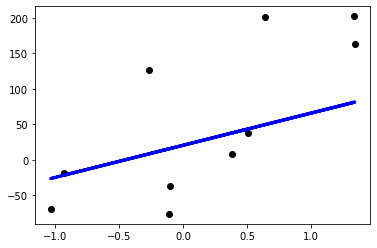

In [19]:
# visualize prediction vs. ground truth
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, prediction, color='blue', linewidth=3)
plt.show()

The above plot visualizes the ground truth (black dots) vs our model prediction (blue line)

## 04) Test with API Gateway

Instead of invoking the Lambda functions directly, we can also use the deployed API gateway, which could be used to offer the train and inference functionality to external applications. 

### 04a) Training

In [20]:
# setup API parameters
url = 'https://ofkwobdov5.execute-api.eu-central-1.amazonaws.com/Prod/training' #paste your API URL here
headers = {'Content-Type': "application/json", 'Accept': "application/json"}

# format payload
data = {
    "data": {
        "X": X.tolist(),
        "y": y.tolist()
    }
}

In [21]:
# invoke API
response = requests.post(url, json=data, headers=headers)

In [23]:
# investicate response
reponse_content = json.loads(response.content)
print(reponse_content)

{'training': 'success', 'mean_squared_error': 468.51680717101283, 'r_squared': 0.7255243071505112}


### 04b) Inference

In [24]:
# setup API parameters
url = 'https://ofkwobdov5.execute-api.eu-central-1.amazonaws.com/Prod/inference' #paste your API URL here
headers = {'Content-Type': "application/json", 'Accept': "application/json"}

# format payload
data = {
    "data": X_test.tolist()
}

In [25]:
# invoke API
response = requests.post(url, json=data, headers=headers)

In [26]:
# investicate response
reponse_content = json.loads(response.content)
print(reponse_content)

{'prediction': '[38.15333039869236, 43.637172535393276, -21.493561545565775, 81.51459109446964, 8.566914120950052, 15.979778754147183, -26.27266089576839, 15.701882234632219, 81.36161387394567, 49.83337368061123]'}
